In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
import scipy
from scipy import io

Mnist data loading 

In [3]:
mat = io.loadmat('../data_image_classif.mat')

X = mat['Xts']

df_y = pd.DataFrame(mat['yts'])
y = pd.get_dummies(df_y[0]).to_numpy() # OneHotEncoding
print(f'y shape : {y.shape}')

X_to_predict = pd.DataFrame(mat['Xvr'])

y shape : (60000, 10)


Documents data loading

In [4]:
mat_doc = io.loadmat('../data_doc_classif.mat')

X_doc = mat_doc['Xts'].T.toarray()

df_y_doc = pd.DataFrame(mat_doc['yts'])
y_doc = pd.get_dummies(df_y_doc[0]).to_numpy() # OneHotEncoding
print(f'y shape : {y_doc.shape}')

X_to_predict_doc = pd.DataFrame(mat_doc['Xvr'].T.toarray())



y shape : (13960, 20)


Documents train set

In [5]:
train_set_doc = [[X_doc[i].reshape(1,-1),y_doc[i].reshape(1,-1)] for i in range(X_doc.shape[0])]
len(train_set_doc)

13960

Mnist train set

In [6]:
train_set = [[X[i].reshape(1,-1),y[i].reshape(1,-1)] for i in range(X.shape[0])]
len(train_set)

60000

In [30]:
class NeuralNet:

    def __init__(self, h_size1, h_size2,train_set, test_set = None, batch_size = None, learn_rate = 0.00001):
        random.shuffle(train_set)
        self.input_size = train_set[0][0].shape[1]
        self.output_size = train_set[0][1].shape[1]
        self.h_size1 = h_size1
        self.h_size2 = h_size2
        self.train_set = train_set
        self.learn_rate = learn_rate
        self.test_set = test_set
        if batch_size is not None:
            self.batch_size = batch_size
        else:
            self.batch_size = len(train_set)

        self.w1 = np.random.randn(self.input_size, h_size1)
        self.b1 = np.random.randn(1, h_size1)

        self.w2 = np.random.randn(h_size1, h_size2)
        self.b2 = np.random.randn(1, h_size2)

        self.w3 = np.random.randn(h_size2, self.output_size)
        self.b3 = np.random.randn(1, self.output_size)

        self.n_iters = len(train_set) // self.batch_size

        self.s1 = 0
        self.h1 = 0

        self.h2 = 0
        self.s2 = 0

        self.s3 = 0
        self.h3 = 0

        self.z = 0

    def relu_deriv(self,t):
    
        return (t >= 0).astype(float)

    def relu(self,t):
        return np.maximum(t,0)

    def stable_softmax(self,x):
        a = x - np.max(x, axis = 1, keepdims = True)
        numerator = np.exp(a)
        denominator = np.sum(numerator, axis = 1, keepdims = True)
        softmax = numerator/denominator
        return softmax


    def forward(self,x):
        self.s1 = np.dot(x, self.w1) + self.b1
#         print(f's1 - {self.s1.shape}')

        self.h1 = self.relu(self.s1)
#         print(f'h1 - {self.h1.shape}')

        self.s2 = np.dot(self.h1, self.w2) + self.b2
#         print(f's2 - {self.s2.shape}')
        
        self.h2 = self.relu(self.s2)
#         print(f'h2 - {self.h2.shape}')

        self.s3 = np.dot(self.h2, self.w3) + self.b3
#         print(f's3 - {self.s3.shape}')

        self.z = self.stable_softmax(self.s3)
#         print(f'z - {self.z.shape}')

        return self.z

    def backward(self,x,y):

        #3 layer

        dloss_dS3  = 2*(self.z - y)/self.batch_size  
#         print(f'dloss_dS3 - {dloss_dS3.shape}')

        dloss_dW3 = self.h2.T @ dloss_dS3
#         print(f'dloss_dW3 - {dloss_dW3.shape}')

        dloss_db3 = np.sum(dloss_dS3, axis = 0, keepdims = True)
#         print(f'dloss_db3 - {dloss_db3.shape}')

        dloss_dh2 = dloss_dS3 @ self.w3.T
#         print(f'dloss_dh2 - {dloss_dh2.shape}')

        # 2 layer
 
        dloss_dS2  = dloss_dh2 * (self.relu_deriv(self.s2)) 
        
        dloss_dW2 = self.h1.T @ dloss_dS2
        
        dloss_db2 = np.sum(dloss_dS2, axis = 0, keepdims = True)
        
        dloss_dh1 = dloss_dS2 @ self.w2.T
        
        # 1 layer
        dloss_dS1  = dloss_dh1*self.relu_deriv(self.s1)
        
        dloss_dW1 = x.T @ dloss_dS1
        
        dloss_db1 = np.sum(dloss_dS1, axis = 0, keepdims=True)
        
        self.w1 = self.w1 - self.learn_rate *dloss_dW1
        self.b1 = self.b1 - self.learn_rate *dloss_db1
        
        self.w2 = self.w2 - self.learn_rate *dloss_dW2
        self.b2 = self.b2 - self.learn_rate *dloss_db2

        self.w3 = self.w3 - self.learn_rate *dloss_dW3
        self.b3 = self.b3 - self.learn_rate *dloss_db3

    def batch_set(self,i):
        batch_x, batch_y = zip(*self.train_set[i*self.batch_size : (i+1)*self.batch_size])
        x = np.concatenate(batch_x, axis = 0)
        y = np.concatenate(batch_y, axis = 0)
        return x,y
    
    def parameters(self):

        return self.w1, self.b1, self.w2, self.b2,self.w3, self.b3

    def loss_batch(self, y):
    
        return np.mean(np.mean(((y-self.z)**2), axis = 1))
    
    def accuracy(self, test_set = None):
        if self.test_set is None:
            cur_set = test_set
        else:
            cur_set = self.test_set.copy()
        correct = 0

        for x,y in cur_set:
            z = self.forward(x)
            y_pred = np.argmax(z)
            if y_pred == np.argmax(y):
                correct += 1
                
        acc = correct / len(cur_set)
        return acc


  



In [31]:
n = NeuralNet(392,100, train_set, batch_size = 20000)

In [33]:
n_epochs = 40
loss_list = []
for ep in range(n_epochs):

    for i in range(n.n_iters):
        x,y = n.batch_set(i)
        n.forward(x)
        print(f'ep: {ep+1}/{n_epochs}, i: {i+1}/{n.n_iters}, '
              f'loss - {n.loss_batch(y):.3f}, ')
        loss_list.append(n.loss_batch(y))
        n.backward(x,y)

ep: 1/40, i: 1/3, loss - 0.179, 
ep: 1/40, i: 2/3, loss - 0.174, 
ep: 1/40, i: 3/3, loss - 0.155, 
ep: 2/40, i: 1/3, loss - 0.147, 
ep: 2/40, i: 2/3, loss - 0.138, 
ep: 2/40, i: 3/3, loss - 0.132, 
ep: 3/40, i: 1/3, loss - 0.123, 
ep: 3/40, i: 2/3, loss - 0.120, 
ep: 3/40, i: 3/3, loss - 0.113, 
ep: 4/40, i: 1/3, loss - 0.108, 
ep: 4/40, i: 2/3, loss - 0.107, 
ep: 4/40, i: 3/3, loss - 0.101, 
ep: 5/40, i: 1/3, loss - 0.098, 
ep: 5/40, i: 2/3, loss - 0.097, 
ep: 5/40, i: 3/3, loss - 0.093, 
ep: 6/40, i: 1/3, loss - 0.090, 
ep: 6/40, i: 2/3, loss - 0.090, 
ep: 6/40, i: 3/3, loss - 0.086, 
ep: 7/40, i: 1/3, loss - 0.084, 
ep: 7/40, i: 2/3, loss - 0.084, 
ep: 7/40, i: 3/3, loss - 0.081, 
ep: 8/40, i: 1/3, loss - 0.079, 
ep: 8/40, i: 2/3, loss - 0.080, 
ep: 8/40, i: 3/3, loss - 0.076, 
ep: 9/40, i: 1/3, loss - 0.075, 
ep: 9/40, i: 2/3, loss - 0.076, 
ep: 9/40, i: 3/3, loss - 0.073, 
ep: 10/40, i: 1/3, loss - 0.072, 
ep: 10/40, i: 2/3, loss - 0.073, 
ep: 10/40, i: 3/3, loss - 0.070, 
ep: 11/

In [34]:
n.accuracy(train_set)

0.7898166666666666

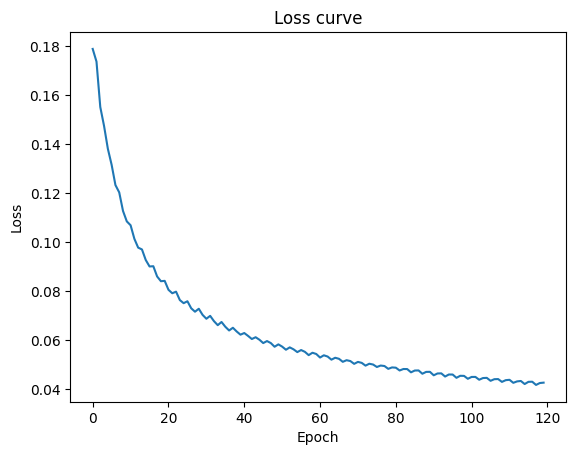

In [36]:
plt.plot(loss_list)
plt.title('Loss curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

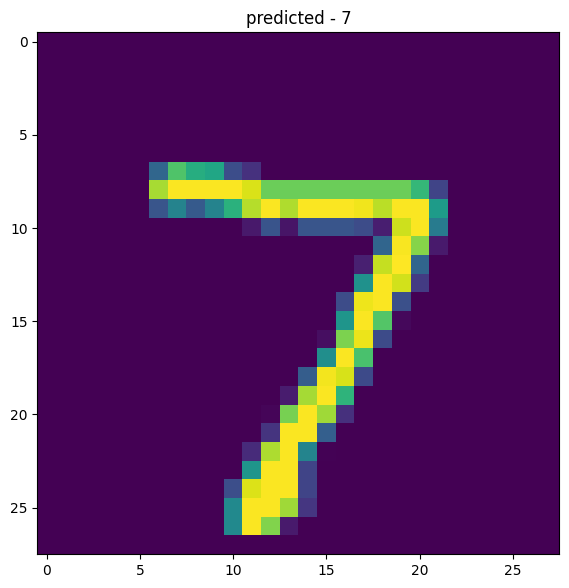

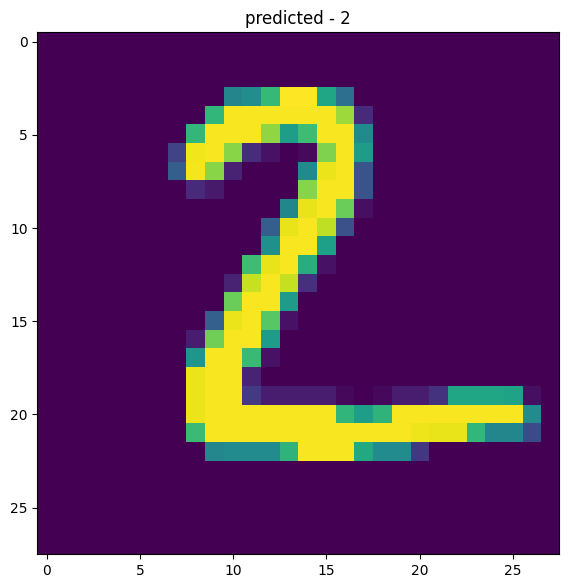

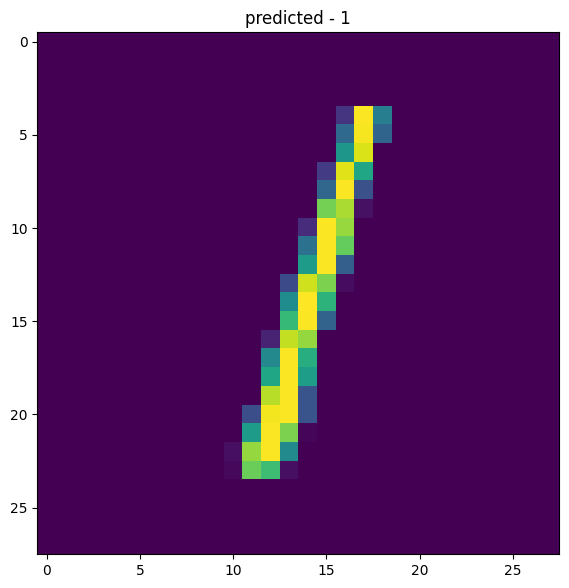

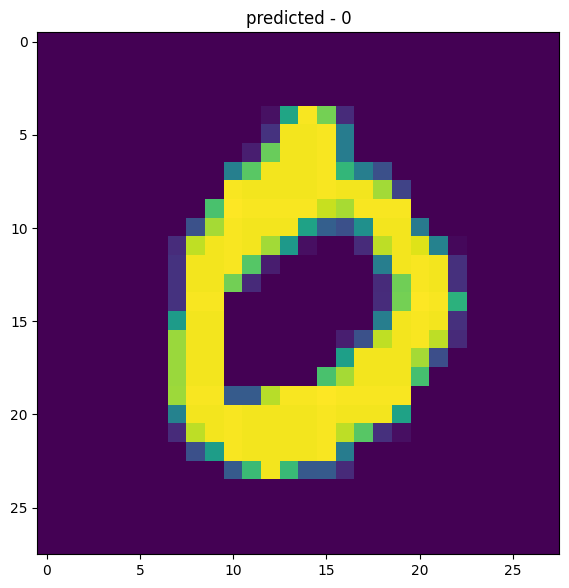

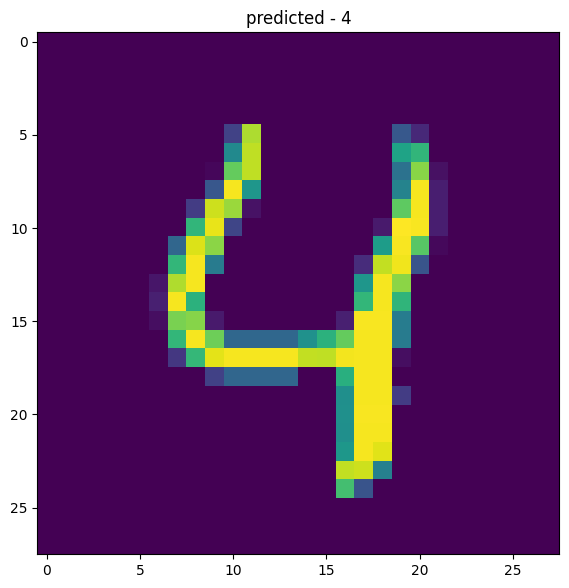

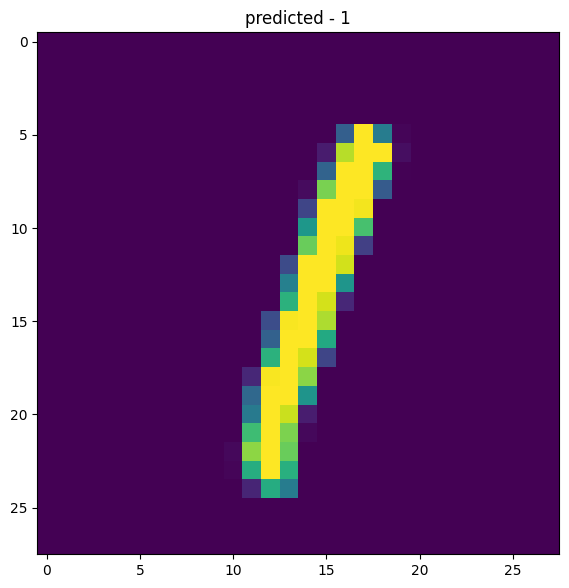

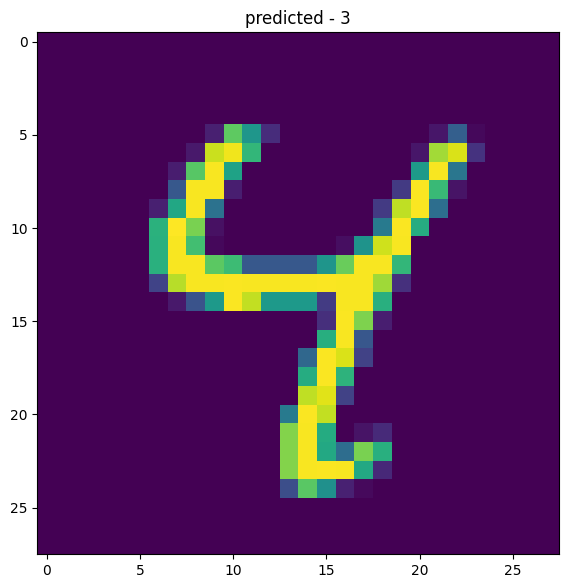

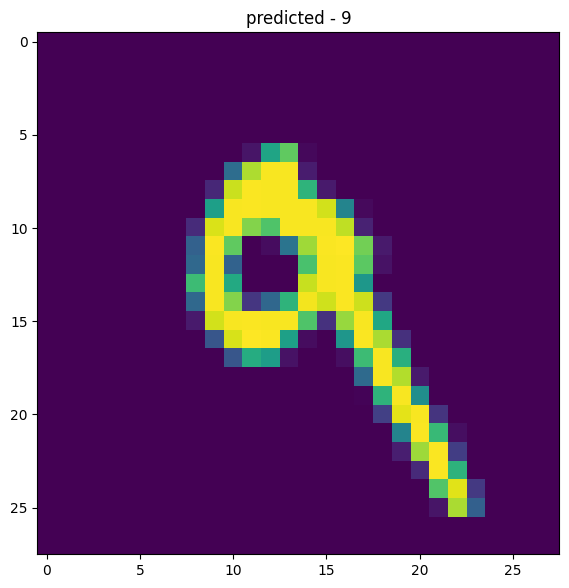

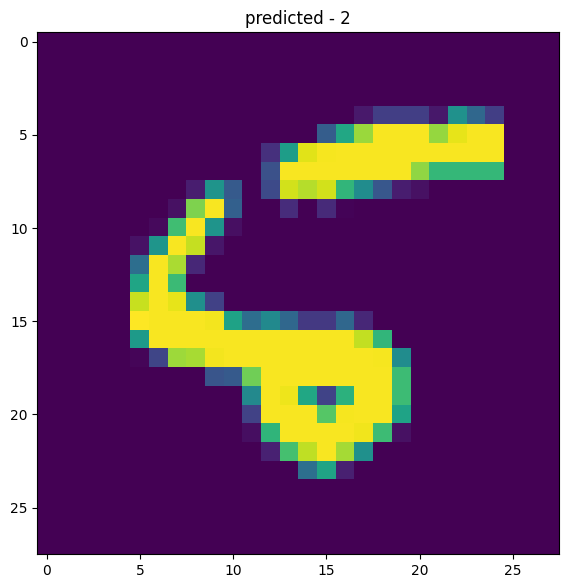

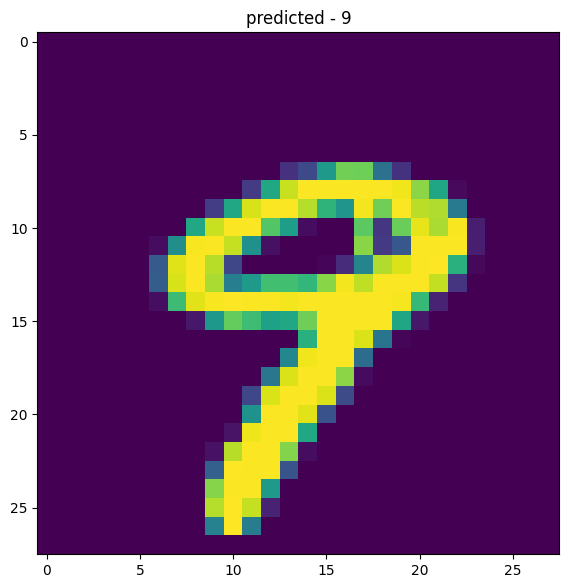

In [37]:
total = 10
for i in range(total):
    plt.figure(figsize = (40,80))
    plt.subplot(total,1,i+1)
    plt.imshow(Xpr[i].reshape(28,28))
    plt.title(f'predicted - {np.argmax(n.forward(Xpr[i]))}')